In [ ]:
from pathlib import Path
import pandas as psd

In [ ]:
def load_all_pairs(folder_path):
    folder = Path(folder_path)
    csv_files = list(folder.glob("*.csv"))
    dfs = []
    for file in csv_files:
        try:
            df = pd.read_csv(file, sep=';', encoding='latin1', header=None)
            df.columns = ['datetime_raw', 'open', 'high', 'low', 'close', 'volume']
            df['pair'] = file.stem

            # conversion datetime
            df['datetime'] = pd.to_datetime(df['datetime_raw'], format='%Y%m%d %H%M%S')

            dfs.append(df)
        except Exception as e:
            print(f"⚠️ Erreur fichier {file.name} :", e)

    return pd.concat(dfs, ignore_index=True)

# 🔁 Utilisation
fx_df = load_all_pairs("data/FX_2024")
print("✅ Données chargées :", fx_df.shape)
display(fx_df.head())

✅ Données chargées : (2228851, 8)


,datetime_raw,open,high,low,close,volume,pair,datetime
0,20240101 170400,179.168,179.171,179.168,179.171,0,GPBJPY,2024-01-01 17:04:00
1,20240101 170500,179.171,179.173,179.143,179.173,0,GPBJPY,2024-01-01 17:05:00
2,20240101 170600,179.181,179.196,179.180,179.196,0,GPBJPY,2024-01-01 17:06:00
3,20240101 170700,179.191,179.196,179.191,179.196,0,GPBJPY,2024-01-01 17:07:00
4,20240101 170800,179.191,179.196,179.191,179.194,0,GPBJPY,2024-01-01 17:08:00


In [32]:
df_15m = fx_df.set_index("datetime").groupby("pair").resample("15min").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).dropna().reset_index()
print("✅ Données chargées :", fx_df.shape)
display(df_15m.head())

✅ Données chargées : (2228851, 8)


,pair,datetime,open,high,low,close,volume
0,AUDUSD,2024-01-01 17:00:00,0.68043,0.68127,0.68043,0.68102,0
1,AUDUSD,2024-01-01 17:15:00,0.68100,0.68154,0.68059,0.68075,0
2,AUDUSD,2024-01-01 17:30:00,0.68077,0.68093,0.68065,0.68092,0
3,AUDUSD,2024-01-01 17:45:00,0.68093,0.68102,0.68045,0.68061,0
4,AUDUSD,2024-01-01 18:00:00,0.68067,0.68122,0.68067,0.68106,0


Log returns

$
r_{pair}(t)=log(\frac{closet}{closet-1})
$

In [40]:
import pandas as pd
import numpy as np

# 🔁 Regrouper en chandeliers M15
df_15m = fx_df.set_index("datetime").groupby("pair").resample("15min").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).dropna().reset_index()

# ✅ Calcul du log return par paire
df_15m['log_return'] = df_15m.groupby('pair')['close'].transform(lambda x: np.log(x / x.shift(1)))

# 🔍 Extraire base et quote
df_15m['base'] = df_15m['pair'].str[:3]
df_15m['quote'] = df_15m['pair'].str[3:]

# 🔀 Calcul des forces pour chaque devise
base_strength = df_15m[['datetime', 'base', 'log_return']].copy()
base_strength.columns = ['datetime', 'currency', 'strength']

quote_strength = df_15m[['datetime', 'quote', 'log_return']].copy()
quote_strength['log_return'] *= -1
quote_strength.columns = ['datetime', 'currency', 'strength']

# 🔗 Fusion des forces
csi_df = pd.concat([base_strength, quote_strength])

# 🧱 Somme par datetime/devise
csi_grouped = csi_df.groupby(['datetime', 'currency'])['strength'].sum()

# 📈 Somme cumulée dans le temps (cœur du CSI Quantum)
csi_cumulative = (
    csi_grouped
    .groupby('currency')
    .cumsum()
    .unstack()
)

# (optionnel) Lissage
csi_smoothed = csi_cumulative.rolling(window=10, min_periods=1).mean()

# ✅ Résultat prêt pour le graphe
display(csi_smoothed.tail())

currency,AUD,CHF,EUR,GPB,JPY,NZD,USD
datetime,,,,,,,
2024-12-31 15:45:00,-0.095577,-0.014029,-0.050041,0.094013,-0.204596,-0.121645,0.391875
2024-12-31 16:00:00,-0.095574,-0.014055,-0.049987,0.094119,-0.204751,-0.121666,0.391914
2024-12-31 16:15:00,-0.095562,-0.014059,-0.049930,0.094174,-0.204806,-0.121657,0.391840
2024-12-31 16:30:00,-0.095625,-0.014008,-0.050019,0.094147,-0.204769,-0.121716,0.391992
2024-12-31 16:45:00,-0.095654,-0.013958,-0.050125,0.094059,-0.204642,-0.121745,0.392066


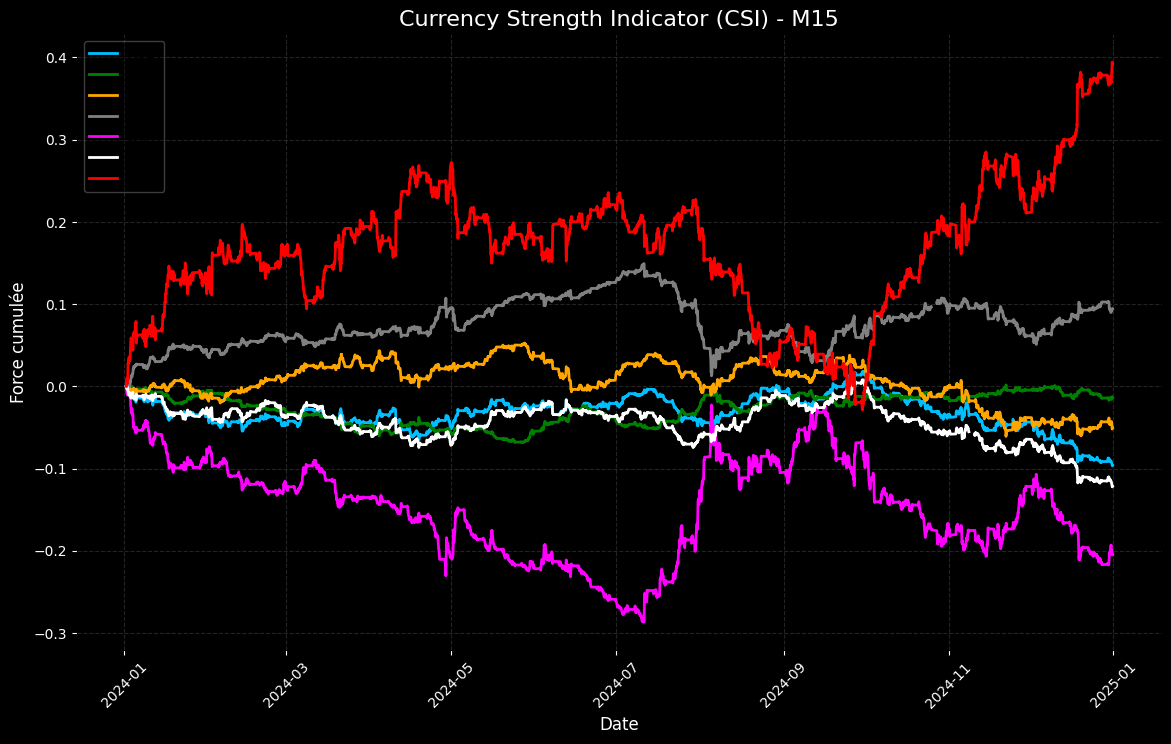

In [41]:
import matplotlib.pyplot as plt

# 📏 Taille de la figure
plt.figure(figsize=(14, 8))

# 🎨 Couleurs par devise
color_map = {
    "USD": "red",
    "EUR": "orange",
    "GBP": "yellowgreen",
    "CHF": "green",
    "JPY": "magenta",
    "CAD": "blue",
    "AUD": "deepskyblue",
    "NZD": "white"
}

# 📈 Tracer chaque devise
for currency in csi_smoothed.columns:
    plt.plot(csi_smoothed.index, csi_smoothed[currency], label=currency,
             color=color_map.get(currency, 'gray'), linewidth=2)

# 🎯 Réglages esthétiques
plt.title("Currency Strength Indicator (CSI) - M15", fontsize=16, color='white')
plt.grid(True, linestyle="--", alpha=0.2)
plt.legend(loc="upper left", fontsize=10)
plt.xlabel("Date", fontsize=12, color='white')
plt.ylabel("Force cumulée", fontsize=12, color='white')
plt.xticks(rotation=45)
plt.gca().set_facecolor("black")
plt.gcf().patch.set_facecolor('black')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.legend(facecolor='black', framealpha=0.3)

# 📈 Afficher
plt.show()

In [6]:
def get_pair_score(csi_df, pair, date="2024-01-01", period="1D"):
    import pandas as pd

    # 🔁 Extraire les devises
    base, quote = pair[:3].upper(), pair[3:].upper()

    # ✅ Vérifier et convertir l'index datetime
    if not isinstance(csi_df.index, pd.DatetimeIndex):
        try:
            csi_df.index = pd.to_datetime(csi_df.index)
        except Exception as e:
            print("❌ Erreur de conversion datetime :", e)
            return None

    # 📆 Définir la période
    try:
        start = pd.to_datetime(date)
        end = start + pd.to_timedelta(period)
    except Exception as e:
        print("❌ Erreur de parsing date/période :", e)
        return None

    # 🔍 Filtrer les données
    filtered = csi_df.loc[(csi_df.index >= start) & (csi_df.index < end)]

    if filtered.empty:
        print(f"⚠️ Aucune donnée disponible entre {start} et {end}")
        return None

    if base not in filtered.columns or quote not in filtered.columns:
        print(f"⚠️ Données manquantes pour {base} ou {quote} dans cette période.")
        return None

    # 📊 Calcul du score net de la paire
    base_score = filtered[base].mean()
    quote_score = filtered[quote].mean()
    net_score = base_score - quote_score

    print(f"📊 Score moyen de {pair} du {start.date()} au {end.date()} : {net_score:.5f}")
    return net_score

In [4]:
get_pair_score(csi_df, "EURUSD", date="2024-01-01", period="3D")
get_pair_score(csi_df, "AUDJPY", date="2024-01-05", period="1D")
print("📅 Dates disponibles :", csi_df.index.min(), "→", csi_df.index.max())

NameError: name 'csi_df' is not defined